In [ ]:
%pip install optuna
%pip install grpcio==1.70.0
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.72.1
    Uninstalling grpcio-1.72.1:
      Successfully uninstalled grpcio-1.72.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires grpcio>=1.71.0, but you have grpcio 1.70.0 which is incompatible.


In [ ]:
# %pip install datasets
# %pip install optuna
# %pip install grpcio==1.70.0
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import os
import json
import torch.nn.functional as F
from pathlib import Path
from shutil import copyfile
from typing import List, Dict, Union, Callable, Optional
from copy import deepcopy
import torch
import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib as plt

import numpy as np

import os

import pdb
from torch.nn import BCELoss
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [ ]:
num_objects = 3
x_size = 40
y_size = 30
processing = True

# Load Data

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from tqdm import tqdm # Assuming you have tqdm installed for the progress bar
import torch.nn.functional as F


# --- Your Dataset Source Code Integration ---
# Assume these are defined earlier or imported from a utility file
# x_size and y_size are needed for SimpleClassifier and processed_train
# Let's infer them from your data if possible, or you need to define them.
# Based on your previous description of (4, 40, 30), it seems x_size=40, y_size=30.
x_size = 40
y_size = 30
num_channels = 4 # This will change after your processing
num_objects = 1 # Assuming this is derived from your labels_data or defined elsewhere

# Dummy processing flag - in your actual script, this would be determined by context
processing = True

if processing is True:
    class myDataset(Dataset):
        """
        Dataset class for NuScenes tensor files.

        Args:
            training_data: Tensor of shape [num_samples, channels, height, width]
            labels_data: Tensor of labels corresponding to training data
        """
        def __init__(self, training_data, labels_data):
            self.training_data = training_data
            self.labels_data = labels_data

            # Verify shapes match
            assert len(training_data) == len(labels_data), "Training data and labels must have same number of samples"

        def __len__(self):
            return len(self.training_data)

        def __getitem__(self, idx):
            # Detach tensors and clone to ensure no gradient history and independent data
            input_tensor = self.training_data[idx].detach().clone()
            label_tensor = self.labels_data[idx].detach().clone()
            return input_tensor, label_tensor

    train_path = fr'/content/training_batch_3_meter_grid.pt'
    labels_path = fr'/content/label_batch_3_meter_grid.pt'

    train_raw = torch.load(train_path, map_location=torch.device('cpu'))
    labels_raw = torch.load(labels_path, map_location=torch.device('cpu')) # Renamed to avoid conflict

    def calc_prior_probs(train, labels, pos=True):
        obj_cases = []
        # Ensure lidar_tensor is taken from the correct channel if train has more than 1
        # Based on your predict_lidar_probability, it seems train[:, 0, :, :] is the lidar channel
        lidar_tensor = train[:, 0, :, :].numpy()
        num_objects = labels.size()[1] # Assuming labels are (num_samples, num_objects, H, W)
        for i in range(num_objects):
            d = {}
            obj_label = labels[:, i, :, :].numpy()
            if pos is True:
                object_present_mask = (obj_label > 0.5)
            else:
                object_present_mask = (obj_label < 0.5)
            lidar_values_where_object = lidar_tensor[object_present_mask]
            lidar_values_where_object = np.round(lidar_values_where_object * 10) / 10
            unique_values, counts = np.unique(lidar_values_where_object, return_counts=True)
            obj_cases.append([unique_values, counts])
        return obj_cases

    class SimpleClassifier(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(SimpleClassifier, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()
        def forward(self, x):
            x_size_local, y_size_local = x.shape # Capture original 2D shape
            x = x.flatten() # Flatten the input
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            x = self.sigmoid(x)
            x = x.view(x_size_local, y_size_local) # Reshape back to 2D
            return x

    # Assuming x_size and y_size are correctly defined for your data
    prob_lidar_model = SimpleClassifier(input_size=x_size * y_size, hidden_size=x_size * y_size * 64, output_size=x_size * y_size)
    state_dict = torch.load(fr'/content/simple_classifier_state_dict.pth', map_location=torch.device('cpu'))
    prob_lidar_model.load_state_dict(state_dict)
    prob_lidar_model.eval()  # Set to evaluation mode

    def predict_lidar_ptobability(tensor_data):
        """Replaces intensity values in lidar_data with likelihoods from cases_dict.

        Args:
        lidar_data: A tensor representing lidar data.
        cases_dict: A dictionary mapping discretized intensity values to likelihoods.

        Returns:
        A tensor with intensity values replaced by likelihoods.
        """
        lidar_data = tensor_data[0, :, :] # Assumes lidar is the first channel

        new_lidar_data = lidar_data.clone()
        lidar_data_prob = prob_lidar_model(new_lidar_data)
        # lidar_data_prob = lidar_data_prob # This line seems redundant

        return lidar_data_prob.unsqueeze(0) # Add channel dimension back

    def process_tensor(tensor):
        """
        Processes a tensor based on the provided criteria.

        Args:
            tensor: The input tensor.

        Returns:
            A list of tensors.
        """
        optical_tensor = tensor[1:4, :, :] / 1000 # Assuming channels 1,2,3 are optical
        return optical_tensor

    # Dynamically determine the number of channels after processing
    # lidar_prob_map will be 1 channel, optical_tensors will be 3 channels
    # So, num_channels_after_processing will be 1 + 3 = 4
    num_channels_after_processing = 4
    # The output shape will be (num_samples, num_channels_after_processing, x_size, y_size)

    # Initialize processed_train with the correct inferred size
    processed_train = torch.empty(0, num_channels_after_processing, x_size, y_size)

    # Use train_raw and labels_raw as the source for processing
    for i in tqdm(range(train_raw.size()[0])):
        tensor_to_process = train_raw[i]
        optical_tensors = process_tensor(tensor_to_process)
        lidar_prob_map = predict_lidar_ptobability(tensor_to_process)
        concat_lidar_opt = torch.cat([lidar_prob_map, optical_tensors], dim=0)
        processed_train = torch.cat((processed_train, concat_lidar_opt.unsqueeze(0)), dim=0)

    training_set = myDataset(processed_train, labels_raw) # Use labels_raw here

    total_size = len(processed_train)
    train_split_ratio = 0.85
    train_size = int(train_split_ratio * total_size)
    test_size = total_size - train_size

    generator = torch.Generator().manual_seed(42)
    torch.manual_seed(42)

    train_dataset, test_dataset = random_split(training_set, [train_size, test_size], generator=generator)

100%|██████████| 820/820 [01:09<00:00, 11.79it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedBCELoss(nn.BCELoss):
    """
    Weighted Binary Cross Entropy Loss that applies higher weights to positive examples.
    Inherits from PyTorch's BCELoss for compatibility.

    Args:
        pos_weight: Weight multiplier for positive examples (default: 10.0)
        reduction: Specifies the reduction to apply to the output ('none', 'mean', 'sum')
    """
    def __init__(self, pos_weight=10.0, reduction='mean'):
        # BCELoss constructor takes (weight, size_average, reduce, reduction)
        # We handle the 'pos_weight' manually in forward, so no need to pass it here directly.
        super(WeightedBCELoss, self).__init__(reduction=reduction)

        if not isinstance(pos_weight, (int, float)) or pos_weight <= 0:
            raise ValueError("pos_weight must be a positive number.")
        self.pos_weight = float(pos_weight) # Ensure it's a float for calculations
        self.reduction = reduction

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for weighted BCE loss.

        Args:
            input: Predicted probabilities (B, ...), must be in [0, 1] range.
            target: Ground truth binary values (B, ...), must be 0 or 1.

        Returns:
            Weighted BCE loss.
        """
        # --- Robustness Checks for Inputs ---
        if not torch.is_floating_point(input):
            raise TypeError(f"Input tensor must be of floating point type. Got: {input.dtype}")
        if not torch.is_floating_point(target):
            raise TypeError(f"Target tensor must be of floating point type. Got: {target.dtype}")

        if input.shape != target.shape:
            raise ValueError(f"Input and target tensors must have the same shape. Got input: {input.shape}, target: {target.shape}")

        # Check for NaN/Inf in inputs before passing to F.binary_cross_entropy
        if torch.isnan(input).any():
            raise ValueError("Input tensor contains NaN values. Please check your model outputs.")
        if torch.isinf(input).any():
            raise ValueError("Input tensor contains Inf values. Please check your model outputs (e.g., exploding gradients).")
        if torch.isnan(target).any():
            raise ValueError("Target tensor contains NaN values. Please check your data loading.")
        if torch.isinf(target).any():
            raise ValueError("Target tensor contains Inf values. Please check your data loading.")

        # Check if input probabilities are within [0, 1]
        if input.min() < 0.0 or input.max() > 1.0:
            raise ValueError(
                f"Input probabilities must be in the range [0, 1]. "
                f"Found min: {input.min().item()}, max: {input.max().item()}."
                f"Ensure your model's last layer is Sigmoid if using BCELoss, or use BCEWithLogitsLoss if outputting logits."
            )

        # Check if target values are strictly 0 or 1
        if not torch.all((target == 0.0) | (target == 1.0)):
            # This identifies the problematic values for easier debugging
            problematic_values = target[~((target == 0.0) | (target == 1.0))]
            raise ValueError(
                f"Target tensor must contain only 0.0 or 1.0 values for binary classification. "
                f"Found problematic values: {problematic_values.unique().tolist()}."
            )
        # --- End Robustness Checks ---

        # Create weight tensor where positive examples get higher weight
        # Ensure 'weights' tensor is on the same device as 'target'
        weights = torch.ones_like(target, device=target.device, dtype=target.dtype)
        weights[target == 1.0] = self.pos_weight

        # Calculate BCE loss element-wise (without reduction)
        # F.binary_cross_entropy requires float inputs
        bce = F.binary_cross_entropy(input, target, reduction='none')

        # Apply custom weights to the loss
        weighted_bce = bce * weights

        # Apply reduction as specified
        if self.reduction == 'mean':
            return weighted_bce.mean()
        elif self.reduction == 'sum':
            return weighted_bce.sum()
        else:  # 'none'
            return weighted_bce

In [ ]:
# After your processing loop, add these lines:
print("Final validation:")
print(f"Processed data min: {processed_train.min():.4f}")
print(f"Processed data max: {processed_train.max():.4f}")

if processed_train.min() < 0 or processed_train.max() > 1:
    print("ERROR: Some values are outside [0,1] range!")
else:
    print("✓ All values are within [0,1] range")

Final validation:
Processed data min: 0.0000
Processed data max: 1.0000
✓ All values are within [0,1] range


In [ ]:
# train_dataset = torch.load("/kaggle/working/test_dataset.pt")
# test_dataset = torch.load("/kaggle/working/test_dataset.pt")

In [ ]:
def plot_loss(train_loss, test_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'bo-', label='Train loss')
    plt.plot(epochs, test_loss, 'ro-', label='Test loss')
    plt.title('Training and Testing Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
class WeightedBCELoss(nn.BCELoss):
    """
    Weighted Binary Cross Entropy Loss that applies higher weights to positive examples.
    Inherits from PyTorch's BCELoss for compatibility.

    Args:
        pos_weight: Weight multiplier for positive examples (default: 10.0)
        reduction: Specifies the reduction to apply to the output ('none', 'mean', 'sum')
        weight: A manual rescaling weight given to the loss of each batch element
    """
    def __init__(self, pos_weight=10.0, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(WeightedBCELoss, self).__init__(weight, size_average, reduce, reduction)
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, input, target):
        """
        Forward pass for weighted BCE loss

        Args:
            input: Predicted probabilities (B, ...)
            target: Ground truth binary values (B, ...)

        Returns:
            Weighted BCE loss
        """
        # Create weight tensor where positive examples get higher weight
        weights = torch.ones_like(target)
        weights[target == 1] = self.pos_weight

        # Calculate BCE loss element-wise (without reduction)
        bce = F.binary_cross_entropy(input, target, reduction='none')

        # Apply weights to the loss
        weighted_bce = bce * weights

        # Apply reduction
        if self.reduction == 'mean':
            return weighted_bce.mean()
        elif self.reduction == 'sum':
            return weighted_bce.sum()
        else:  # 'none'
            return weighted_bce

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# הגדרת פרמטרים
# הערה: יש לוודא שמשתנים אלו (x_size, y_size, num_objects) מוגדרים בקוד שלך
# לפני יצירת מופע של המחלקה SimpleCNN
# לדוגמה:
x_size = 40
y_size = 30
num_objects = 3 # אם num_objects = 3, אז input_channels יהיה 4

class ResidualCNN(nn.Module):
    """Alternative architecture with residual connections for deeper networks"""

    def __init__(self, x_size=40, y_size=30, num_objects=3):
        super(ResidualCNN, self).__init__()

        input_channels = num_objects + 1
        output_channels = num_objects

        # Initial convolution
        self.initial_conv = nn.Conv2d(input_channels, 64, kernel_size=7, padding=3)
        self.initial_bn = nn.BatchNorm2d(64)

        # Residual blocks
        self.res_block1 = self._make_residual_block(64, 64)
        self.res_block2 = self._make_residual_block(64, 128, stride=2)
        self.res_block3 = self._make_residual_block(128, 256, stride=2)

        # Upsampling layers
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, output_channels, kernel_size=1),
            nn.Sigmoid()
        )

        self.dropout = nn.Dropout2d(0.1)

    def _make_residual_block(self, in_channels, out_channels, stride=1):
        layers = []

        # First conv block
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        # Second conv block
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))

        block = nn.Sequential(*layers)

        # Skip connection handling
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        return block

    def forward(self, x):
        # Initial processing
        out = F.relu(self.initial_bn(self.initial_conv(x)))

        # Residual blocks with skip connections
        identity = out
        out = self.res_block1(out)
        out += identity  # Skip connection
        out = F.relu(out)

        out = self.res_block2(out)
        out = self.res_block3(out)
        out = self.dropout(out)

        # Upsampling
        out = F.relu(self.upsample1(out))
        out = F.relu(self.upsample2(out))

        # Ensure correct output size
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)

        # Final output
        out = self.final_layers(out)

        return out


In [ ]:
# prompt: write a training code for the SimpleCNN above

def train_model(params, model):
    """
    Trains the SimpleCNN model and evaluates it on the test set.

    Args:
        model: The SimpleCNN model instance.
        train_loader: DataLoader for the training data.
        test_loader: DataLoader for the testing data.
        criterion: The loss function.
        optimizer: The optimizer.
        num_epochs: Number of training epochs.

    Returns:
        Tuple containing lists of train loss and test loss per epoch.
    """

    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    pos_weight = params["pos_weight"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    test_loss_history = []

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    criterion = WeightedBCELoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # Apply sigmoid to outputs to get probabilities for BCELoss
            outputs = torch.sigmoid(outputs)

            # Calculate loss
            # Ensure labels are float as BCELoss expects float type targets
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_train_loss)

        # Evaluate on the test set
        model.eval()  # Set model to evaluation model
        true_labels_lst = []
        test_preds_lst = []
        test_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test] "):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss_epoch = criterion(outputs, labels.float())
                test_running_loss += test_loss_epoch.item() * inputs.size(0)
                if epoch == num_epochs - 1:
                    true_labels_lst.extend(labels.cpu().numpy().flatten())
                    test_preds = (outputs >= 0.5).float()
                    test_preds_lst.extend(test_preds.cpu().numpy().flatten())

        epoch_test_loss = test_running_loss / len(test_loader.dataset)
        test_loss_history.append(epoch_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    display("Accuracy: ", accuracy_score(true_labels_lst, test_preds_lst))
    display("Recall Score: ", recall_score(true_labels_lst, test_preds_lst))
    display("Precision Score: ", precision_score(true_labels_lst, test_preds_lst))
    display("AUC Score: ", roc_auc_score(true_labels_lst, test_preds_lst))
    display("Loss: ",test_loss_history[-1])
    print("Finished Training")
    plot_loss(train_loss_history, test_loss_history)
    return test_loss_history[-1]

[I 2025-06-15 09:44:38,129] A new study created in memory with name: no-name-4ebaa1c3-474e-4d71-9013-06358dcc9137
Epoch 1/10 [Test] : 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


Epoch [1/10], Train Loss: 1.0904, Test Loss: 0.7641


Epoch 2/10 [Test] : 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch [2/10], Train Loss: 1.0689, Test Loss: 0.6922


Epoch 3/10 [Test] : 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Epoch [3/10], Train Loss: 1.0594, Test Loss: 0.6739


Epoch 4/10 [Test] : 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


Epoch [4/10], Train Loss: 1.0503, Test Loss: 0.6614


Epoch 5/10 [Test] : 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch [5/10], Train Loss: 1.0438, Test Loss: 0.6375


Epoch 6/10 [Test] : 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


Epoch [6/10], Train Loss: 1.0365, Test Loss: 0.6334


Epoch 7/10 [Test] : 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch [7/10], Train Loss: 1.0283, Test Loss: 0.6186


Epoch 8/10 [Test] : 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]


Epoch [8/10], Train Loss: 1.0224, Test Loss: 0.6097


Epoch 9/10 [Test] : 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch [9/10], Train Loss: 1.0168, Test Loss: 0.6050


Epoch 10/10 [Test] : 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

Epoch [10/10], Train Loss: 1.0096, Test Loss: 0.6034


'Accuracy: '

0.9065674603174603

'Recall Score: '

0.657283603096411

'Precision Score: '

0.024502216742306987

'AUC Score: '

np.float64(0.7823663615675197)

'Loss: '

0.6034489530857986

Finished Training


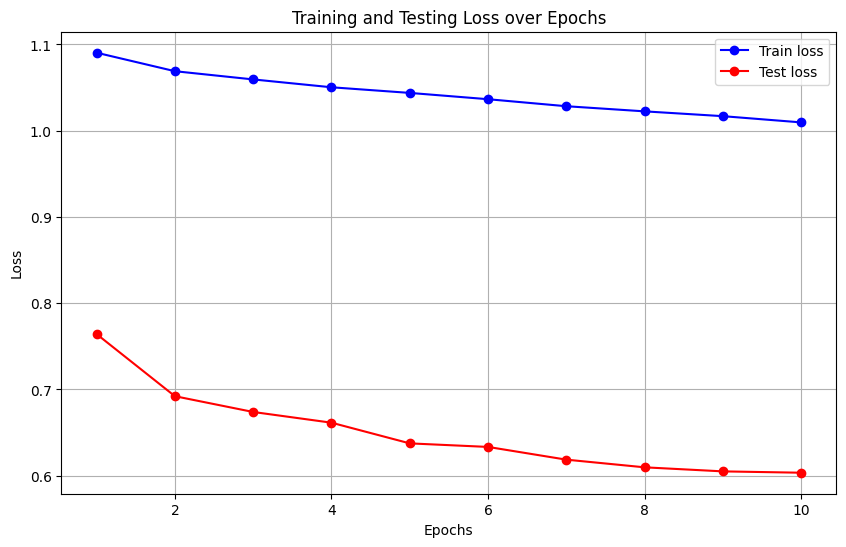

[I 2025-06-15 09:50:51,502] Trial 0 finished with value: 0.6034489530857986 and parameters: {'learning_rate': 5e-05, 'num_epochs': 10, 'batch_size': 16, 'pos_weight': 100}. Best is trial 0 with value: 0.6034489530857986.


Best hyperparameters: {'learning_rate': 5e-05, 'num_epochs': 10, 'batch_size': 16, 'pos_weight': 100}


In [ ]:
def objective(trial):
    avg_test_loss_lst = []
    avg_train_loss_lst = []
    learning_rate = trial.suggest_categorical('learning_rate',[1e-1,5e-2, 1e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6])
    num_epochs = trial.suggest_int('num_epochs', 5, 12)
    batch_size = trial.suggest_categorical('batch_size', [16])
    pos_weight = trial.suggest_categorical('pos_weight', [10, 50, 100])
    model = ResidualCNN()
    test_loss = train_model(trial.params, model)
    return test_loss
study = optuna.create_study(direction='minimize')
# study.enqueue_trial(params = {'learning_rate': 0.1, 'num_epochs': 15, 'batch_size': 16, 'num_layers_to_train': 10})
study.optimize(objective, n_trials=1)

best_trials = study.best_trials
best_params = [param.params for param in best_trials][0]
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

In [ ]:
# prompt: print the number of model parameters of ResidualCNN

# Initialize the model
model = ResidualCNN()

# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Number of trainable parameters: {trainable_params}")


Total number of parameters: 1902787
Number of trainable parameters: 1902787
